# Stellar mass estimation for the GLADE+ galaxies

This notebook contains the stellar mass estimation for the GLADE+ galaxies with two different methods, the comparison of them, some other analysis and the calculation of the merger rate of compact binaries based on the stellar mass.

The code was written by Mária Pálfi (marika97@caesar.elte.hu).

In [1]:
# importing useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math
from scipy.optimize import curve_fit
import seaborn as sns
plt.style.use('seaborn-white') # set figure style

# Reading the catalog

This catalog was created by the *create_working_catalog.ipynb*.

In [2]:
# reading the file to 'data' pandas dataframe
data = pd.read_csv( 'data_for_work.txt', delimiter = '\t', low_memory = False )
print( 'dataframe with the necessary columns:\n' )
data

dataframe with the necessary columns:



,GWGC,Hyp,2MASS,wiseX,type,ra,dec,W1,W2,z,lumdis,lumdis_err,w1mCorr,w1mCorrErr,w2mCorr,w2mCorrErr,fromAllSky
0,NGC4736,NGC4736,12505314+4107125,J125053.14+410712.7,G,192.721451,41.120152,5.611000,6.120000,0.000991,4.392418,NaN,NaN,NaN,NaN,NaN,NaN
1,NGC4548,NGC4548,12352642+1429467,J123526.45+142946.9,G,188.860123,14.496320,9.416000,9.306000,0.004120,15.876007,3.263033,NaN,NaN,NaN,NaN,NaN
2,NGC6503,NGC6503,17492651+7008396,J174926.45+700840.8,G,267.360474,70.144341,10.180000,10.102000,0.001000,12.446600,0.987781,NaN,NaN,NaN,NaN,NaN
3,NGC4442,NGC4442,12280389+0948130,J122803.90+094813.3,G,187.016220,9.803620,8.476000,8.504000,0.003557,11.461371,2.484465,NaN,NaN,NaN,NaN,NaN
4,NGC4469,NGC4469,NaN,J122928.05+084500.8,G,187.367000,8.749890,9.784000,9.706000,0.004139,15.180920,3.321809,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23181753,NaN,NaN,NaN,NaN,Q,359.999118,28.954734,17.728901,16.535843,2.452000,20403.464630,NaN,NaN,NaN,NaN,NaN,NaN
23181754,NaN,NaN,NaN,NaN,Q,359.999303,34.720842,16.933657,15.875454,3.109000,27158.368406,NaN,NaN,NaN,NaN,NaN,NaN
23181755,NaN,NaN,NaN,NaN,Q,359.999615,3.268586,14.833991,13.702355,1.232962,8792.439985,NaN,NaN,NaN,NaN,NaN,NaN
23181756,NaN,NaN,NaN,NaN,Q,359.999759,20.721079,16.979166,16.091722,2.009865,16022.500633,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.columns

Index(['GWGC', 'Hyp', '2MASS', 'wiseX', 'type', 'ra', 'dec', 'W1', 'W2', 'z',
       'lumdis', 'lumdis_err', 'w1mCorr', 'w1mCorrErr', 'w2mCorr',
       'w2mCorrErr', 'fromAllSky'],
      dtype='object')

## Filtration

In [4]:
# We need only the galaxies, therefore we filtrate the quasars ('Q'):
data_new = copy.deepcopy( data[ data.type != 'Q' ] )
print('Length with galaxies only:', data_new.shape[0])
# we need galaxies having luminosity distance:
data_new = data_new[ ~np.isnan(data_new.lumdis) ] 
print( 'Length with known luminosty distance:', data_new.shape[0])
# Kettlety et al. also filtrated the z < 0.003 galaxies,
# because they may be stellar contamintaion.
data_new = data_new[data_new.z > 0.003 ]
print( 'Number of galaxies with z < 0.003:', len( data_new ))
# We need the WISE magnitude (from the original dataframe):
data_new = data_new[ ~np.isnan(data_new.W1) ]
print('Length with W1:', data_new.shape[0])

Length with galaxies only: 22431348
Length with known luminosty distance: 21884622
Number of galaxies with z < 0.003: 21880121
Length with W1: 21747171


In [5]:
print( 'Galaxies with known luminosity distance error:', len(data_new[~np.isnan(data_new.lumdis_err)]) )

Galaxies with known luminosity distance error: 562370


## Estimaing the stellar mass via Kettlety's method
Kettlety et al. 2018. (MNRAS 473, 776–783 (2018), doi:10.1093/mnras/stx2379)

For passive galaxies:

$$M_*/L_{W1} = 0.65 \pm 0.07$$

$$M_* = 0.65 \cdot L_{W1}$$

This is best for z $\leq$ 0.15.

$$L_{W1} (L_{Sun}) = 10^{−0.4(M −M_{Sun} )},$$  

$$M_{Sun} = 3.24$$ 

$M$ is the absolute magnitude measured in the W1 filter, $W1-W2$ is rest-frame color.


(It was first published in Norris et al. (2014) (Norris M. A., Meidt S., van de Ven G., Schinnerer E, Groves B., Querejeta M., 2014, ApJ, 797, 55).)

The stellar mass can be calculated from the WISE W1 magnitude (m) as:
$$M_* = 0.65 \cdot 10^{-0.4[m+5-5\lg d + 7.1\lg(1+z)-3.24]}$$

I calculate the absolute magnitude:

$$m-M = -5+5 \lg d,$$ 

$$M = m+5-5 \lg d,$$

where $m$ is the apparent magnitude, $d$ is the distance (luminosity distance).

### K correction

With the K correction of the absolute magnitude we can take into account the shifting of the band because of the expansion of the Universe. This means that we measure the light emitted in 'x' band in 'y' band. 

According to Hogg et al. 2002. (https://arxiv.org/abs/astro-ph/0210394):

$$m_R = M_Q + DM + K_{QR},$$

where $m_R$ is the apparent magnitude measured in band $R$, $M_Q$ is the absolute magnitude emitted in band $Q$, $K_{QR}$ is the K correction and DM is the distance modulus:

$$DM = 5 \cdot \lg \frac{D_L}{10 ~pc},$$

where $D_L$ is the luminosity distance.

In Kettlety et al. 2018.:

$$K_ {W1} = - 7.1 \lg( 1 + z )$$


### The uncertainty:
$$\Delta M_*(a,m,d,z) = M_* \cdot \sqrt{ \left(\frac{\Delta a}{a} \right)^2 + |0.4 \cdot \ln(10)|^2 \cdot \Delta m^2+4\cdot \left( \frac{\Delta d}{d}\right)^2 + (0.4\cdot 0.71)^2 \cdot \left( \frac{\Delta z}{|1+z|}\right)^2},$$
where $\Delta a = 0.07$.

In [6]:
# absolute magnitude in the W1 band without K correction:
M1_wKc = data_new.W1 + 5 - 5 * np.log10( data_new.lumdis*1e6 )
print( 'absolute magnitude in the W1 band without K correction:' )
print( M1_wKc[:5] )

# K correction for W1 magnitudes according to Kettlety:
M1_Kettlety = M1_wKc + 7.1 * np.log10(1+data_new.z) 
print( '\nK corrected absolute W1 magnitudes according to Kettlety:' )
print( M1_Kettlety[:5] )

# W1 band luminosity:
M_sun = 3.24
print( '\n$L_{W1}$ luminosity:' )
L_W1_Kettlety = 10**( -0.4 * ( M1_Kettlety - M_sun ) )
print( L_W1_Kettlety[:5] )

# stellar mass:
print( '\nThe stellar mass:' )
M_Kettlety = 0.65*L_W1_Kettlety
M_Kettlety[:5]

absolute magnitude in the W1 band without K correction:
1   -21.587706
3   -21.820183
4   -21.122490
5   -20.092803
6   -21.407693
dtype: float64

K corrected absolute W1 magnitudes according to Kettlety:
1   -21.575030
3   -21.809235
4   -21.109755
5   -20.082583
6   -21.394339
dtype: float64

$L_{W1}$ luminosity:
1    8.433579e+09
3    1.046391e+10
4    5.494170e+09
5    2.133208e+09
6    7.140614e+09
dtype: float64

The stellar mass:


1    5.481827e+09
3    6.801542e+09
4    3.571210e+09
5    1.386585e+09
6    4.641399e+09
dtype: float64

In [7]:
# filtrating the small stellar masses:
data_new = data_new[ M_Kettlety > 1e5 ]
M_Kettlety = M_Kettlety[ M_Kettlety > 1e5]

#### Error estimation

If there is no W1 mag error, I use the mean $\Delta m$.

In [8]:
data_new.w1mCorrErr.fillna(np.mean(data_new.w1mCorrErr), inplace = True )

Where do the luminosity distances come from?

According to our assumption the distance originates from that catalog, where the galaxy first appears.

In [9]:
GWGC_idx = np.argwhere( data_new.GWGC.values.astype(str) != 'nan' ).flatten()
Hyp_idx = np.argwhere( data_new.Hyp.values.astype(str) != 'nan' ).flatten()
twoMASS_idx = np.argwhere( data_new['2MASS'].values.astype(str) != 'nan' ).flatten()

cat_flag_W = 4*np.ones( len(data_new), dtype = np.int8 )
# cat_flag = 4: the galaxy first appears in the WISExSCOS
cat_flag_W[twoMASS_idx] = 3 # cat_flag = 3: the galaxy first appears in the 2MASS
cat_flag_W[Hyp_idx] = 2 # cat_flag = 2: the galaxy first appears in the HyperLEDA
cat_flag_W[GWGC_idx] = 1 # cat_flag = 1: the galaxy first appears in the GWGC

data_new['cat_flag'] = cat_flag_W
data_new.head()

,GWGC,Hyp,2MASS,wiseX,type,ra,dec,W1,W2,z,lumdis,lumdis_err,w1mCorr,w1mCorrErr,w2mCorr,w2mCorrErr,fromAllSky,cat_flag
1,NGC4548,NGC4548,12352642+1429467,J123526.45+142946.9,G,188.860123,14.496320,9.416,9.306,0.004120,15.876007,3.263033,NaN,0.043236,NaN,NaN,NaN,1
3,NGC4442,NGC4442,12280389+0948130,J122803.90+094813.3,G,187.016220,9.803620,8.476,8.504,0.003557,11.461371,2.484465,NaN,0.043236,NaN,NaN,NaN,1
4,NGC4469,NGC4469,NaN,J122928.05+084500.8,G,187.367000,8.749890,9.784,9.706,0.004139,15.180920,3.321809,NaN,0.043236,NaN,NaN,NaN,1
5,NGC4586,NGC4586,12382843+0419087,J123828.39+041909,G,189.618484,4.319099,10.055,10.041,0.003320,10.704358,1.756102,NaN,0.043236,NaN,NaN,NaN,1
6,NGC4440,NGC4440,12275357+1217354,J122753.56+121735.8,G,186.973221,12.293191,9.872,9.947,0.004340,18.027630,3.553836,NaN,0.043236,NaN,NaN,NaN,1


Number of galaxies coming from the different catalogs.

In [10]:
(cat_flag_W == 1).sum(), (cat_flag_W == 2).sum(), (cat_flag_W == 3).sum(), (cat_flag_W == 4).sum()

(43608, 1885028, 362589, 19455946)

Relative luminosity distance errors in the different catalogs:

In [11]:
rel_lumdis_err = np.zeros( len(data_new) )

rel_lumdis_err[cat_flag_W == 1] = 0.2
rel_lumdis_err[cat_flag_W == 2] = 0.36
rel_lumdis_err[cat_flag_W == 3] = 0.15
rel_lumdis_err[cat_flag_W == 4] = 0.011

data_new['rel_lumdis_err'] = rel_lumdis_err

Relative redshift errors in the different catalogs:

In [12]:
rel_z_err = np.zeros( len(data_new) )

rel_z_err[cat_flag_W == 1] = 0.19
rel_z_err[cat_flag_W == 2] = 0.36
rel_z_err[cat_flag_W == 3] = 0.15
rel_z_err[cat_flag_W == 4] = 0.033

data_new['rel_z_err'] = rel_z_err

The terms in the error propagation:

In [13]:
sigma_a = (0.07/0.65)**2
sigma_m = (0.4 * np.log(10) * data_new.w1mCorrErr)**2
sigma_d = 4*data_new.rel_lumdis_err**2
sigma_z = (0.4*0.71*1/np.abs(1+data_new.z)*data_new.rel_z_err*data_new.z)**2

Calculating the errors:

In [14]:
rel_err_M_Kettlety = np.sqrt(sigma_a+sigma_m+sigma_d+sigma_z)
err_M_Kettlety = M_Kettlety*rel_err_M_Kettlety

Checking the calculations:

In [15]:
(np.abs(err_M_Kettlety/M_Kettlety - rel_err_M_Kettlety) > 1e-13).sum()

0

#### The mean contribution of the different error terms:

$\mathbf{\sigma_a}$

In [16]:
c_a = np.mean( 100*sigma_a/rel_err_M_Kettlety**2 ) 
c_a

75.52209775565153

$\mathbf{\sigma_m}$

In [17]:
c_m = np.mean( 100*sigma_m/rel_err_M_Kettlety**2 )
c_m

11.218600872327048

$\mathbf{\sigma_d}$

In [18]:
c_d = np.mean( 100*sigma_d/rel_err_M_Kettlety**2 )
c_d

13.236335221601854

$\mathbf{\sigma_z}$

In [19]:
c_z = np.mean( 100*sigma_z/rel_err_M_Kettlety**2 )
c_z

0.022966150428744392

The sum of the percental contribution (sould be close to 100):

In [20]:
c_a + c_m + c_d + c_z

100.00000000000917

Checking the calculation:

In [21]:
(np.abs( (sigma_a + sigma_m + sigma_d+ sigma_z)/rel_err_M_Kettlety**2 - 1 ) > 1e-13 ).sum()

0

**The mean of the relative error in the whole sample and in the different catalogs:**
(whole, GWGC, HyperLEDA, 2MASS, WISExSCOS)

In [22]:
print( np.mean( rel_err_M_Kettlety ),
      np.mean( rel_err_M_Kettlety[ cat_flag_W == 1] ), np.mean( rel_err_M_Kettlety[ cat_flag_W == 2] ),
      np.mean( rel_err_M_Kettlety[ cat_flag_W == 3] ), np.mean( rel_err_M_Kettlety[ cat_flag_W == 4] ) )

0.175019797173504 0.4159343484370641 0.7290570395686129 0.32043114451524357 0.11809087314533669


How many galaxies have stellar mass from this method?

In [23]:
len(M_Kettlety)

21747171

Median error:

In [24]:
np.median(rel_err_M_Kettlety)

0.11624393742118867

### Histogram of the stellar mass

In [25]:
def hist_form( ytext = '$\lg M_{*}$ [$M_\odot$]', logscale = True ):
    fig = plt.figure( figsize = (18, 12), dpi = 100 )
    plt.xlabel( ytext, fontsize = 47 )
    plt.ylabel( 'Frequency', fontsize = 47 )
    if logscale == True:
        plt.yscale('log')
        plt.ylim([1e-1, 1e5])
    plt.xticks( fontsize = 43 )
    plt.yticks( fontsize = 43 )
    plt.tick_params( length=10, direction = 'inout', pad = 5 )

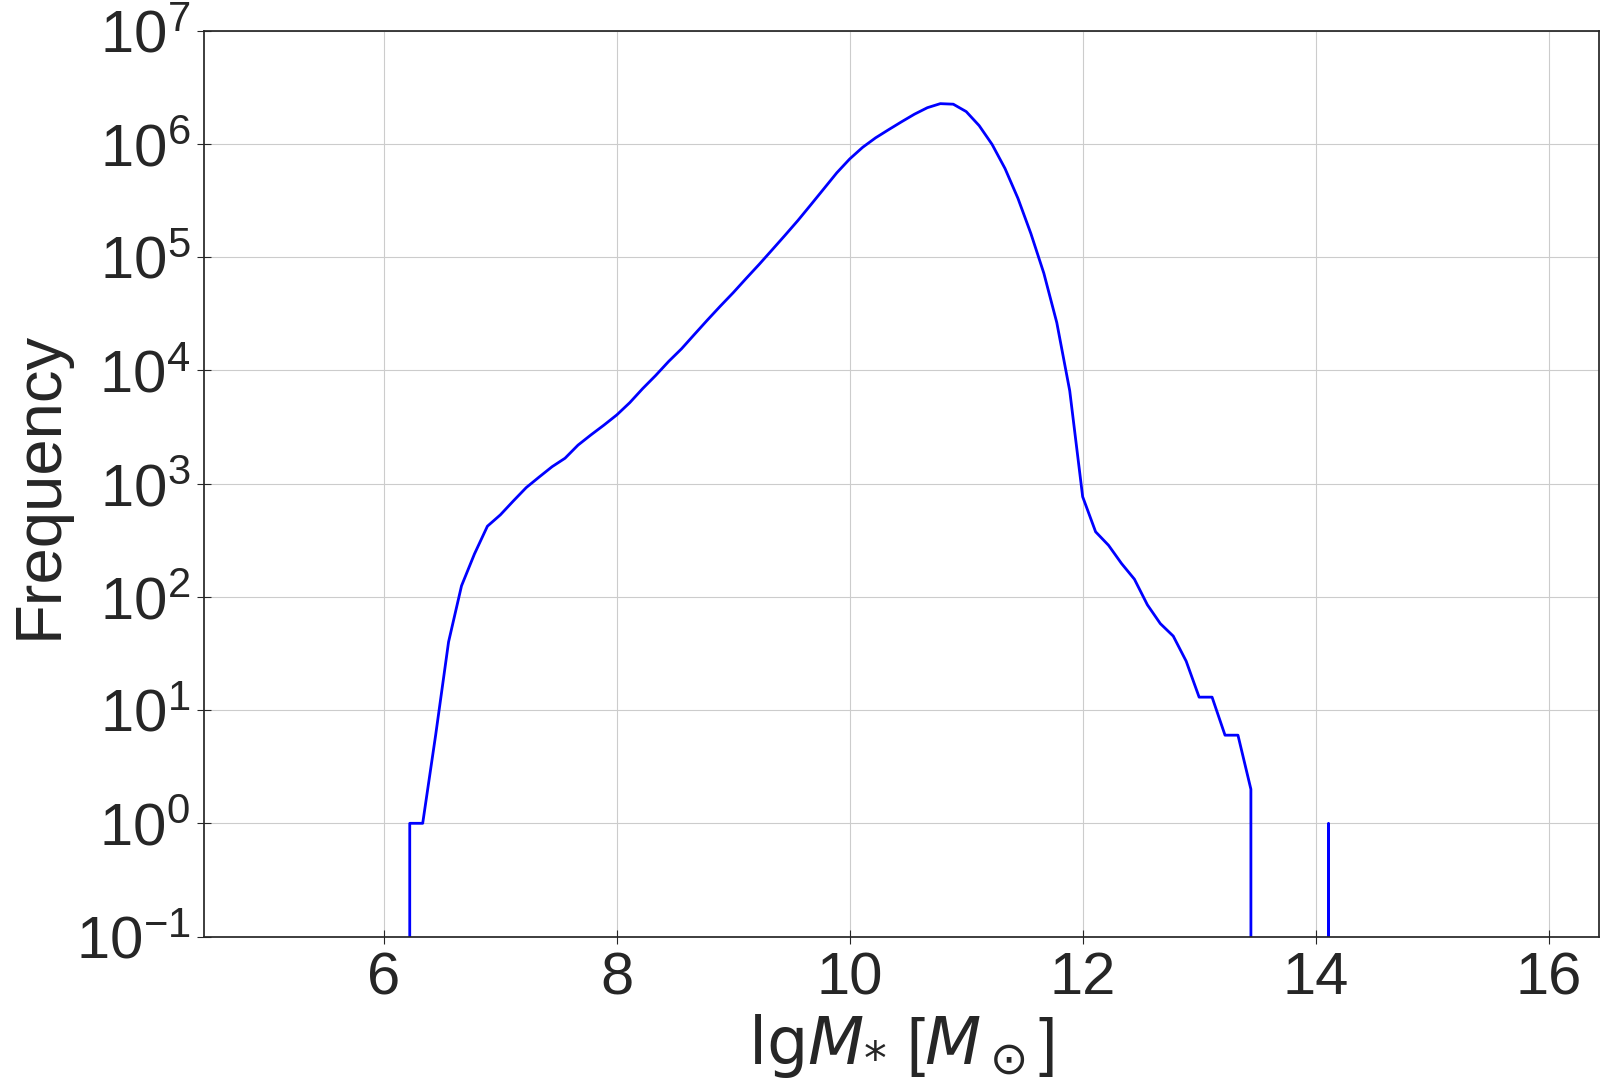

In [26]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(M_Kettlety), bins=np.linspace(5, 16, 100) )
plt.plot( bins[:-1], freq, lw = 2, color = 'blue' ) 
plt.grid()

## Writting the stellar masses to the dataframe

In [27]:
data['SMass_Kettlety'] = M_Kettlety
data['err_SMass_Kettlety'] = err_M_Kettlety

print( 'Data with stellar masses:')
data

Data with stellar masses:


,GWGC,Hyp,2MASS,wiseX,type,ra,dec,W1,W2,z,lumdis,lumdis_err,w1mCorr,w1mCorrErr,w2mCorr,w2mCorrErr,fromAllSky,SMass_Kettlety,err_SMass_Kettlety
0,NGC4736,NGC4736,12505314+4107125,J125053.14+410712.7,G,192.721451,41.120152,5.611000,6.120000,0.000991,4.392418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NGC4548,NGC4548,12352642+1429467,J123526.45+142946.9,G,188.860123,14.496320,9.416000,9.306000,0.004120,15.876007,3.263033,NaN,NaN,NaN,NaN,NaN,5.481827e+09,2.281279e+09
2,NGC6503,NGC6503,17492651+7008396,J174926.45+700840.8,G,267.360474,70.144341,10.180000,10.102000,0.001000,12.446600,0.987781,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NGC4442,NGC4442,12280389+0948130,J122803.90+094813.3,G,187.016220,9.803620,8.476000,8.504000,0.003557,11.461371,2.484465,NaN,NaN,NaN,NaN,NaN,6.801542e+09,2.830483e+09
4,NGC4469,NGC4469,NaN,J122928.05+084500.8,G,187.367000,8.749890,9.784000,9.706000,0.004139,15.180920,3.321809,NaN,NaN,NaN,NaN,NaN,3.571210e+09,1.486171e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23181753,NaN,NaN,NaN,NaN,Q,359.999118,28.954734,17.728901,16.535843,2.452000,20403.464630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23181754,NaN,NaN,NaN,NaN,Q,359.999303,34.720842,16.933657,15.875454,3.109000,27158.368406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23181755,NaN,NaN,NaN,NaN,Q,359.999615,3.268586,14.833991,13.702355,1.232962,8792.439985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23181756,NaN,NaN,NaN,NaN,Q,359.999759,20.721079,16.979166,16.091722,2.009865,16022.500633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### More histograms:

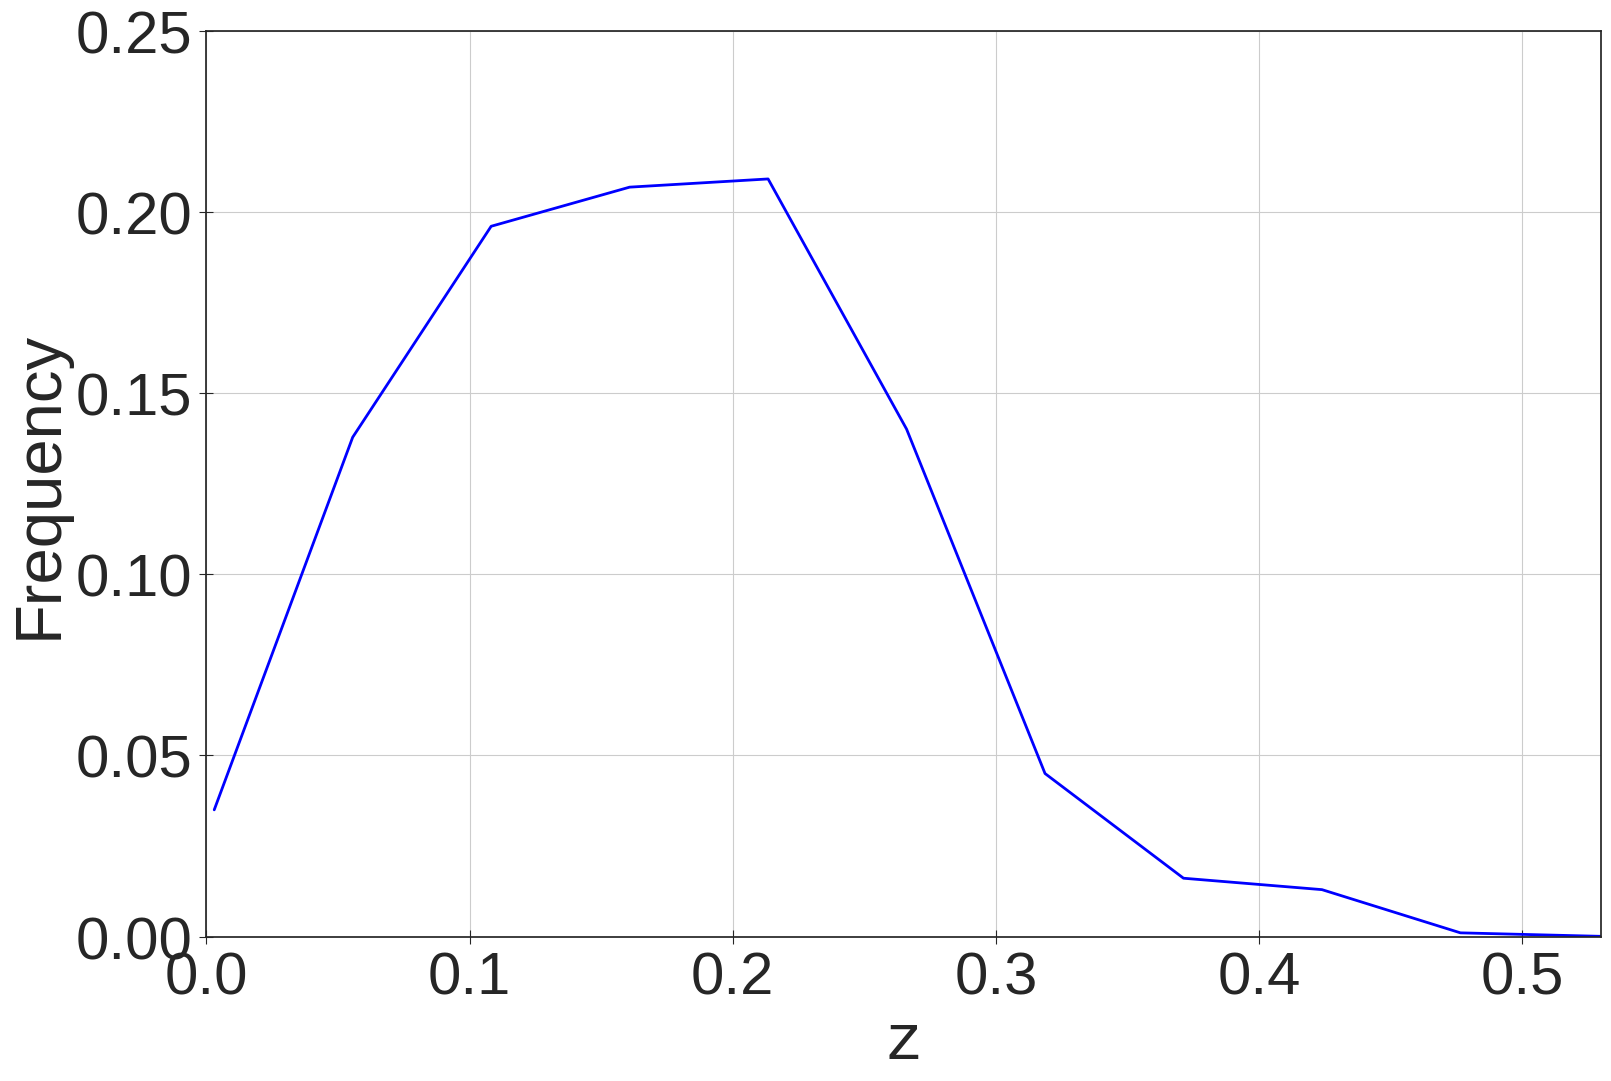

In [28]:
# form the figure:
hist_form()
plt.yscale('linear')
plt.ylim(0,0.25)
plt.xlim(0,0.53)
plt.xlabel('z')
plt.ylabel( 'Frequency' )

# make and plot histograms:
freq, bins = np.histogram( data[~np.isnan(data.SMass_Kettlety)].z, bins=100 )
plt.plot( bins[:-1], freq/len(data[~np.isnan(data.SMass_Kettlety)]),  lw = 2, color = 'blue' )
plt.grid()

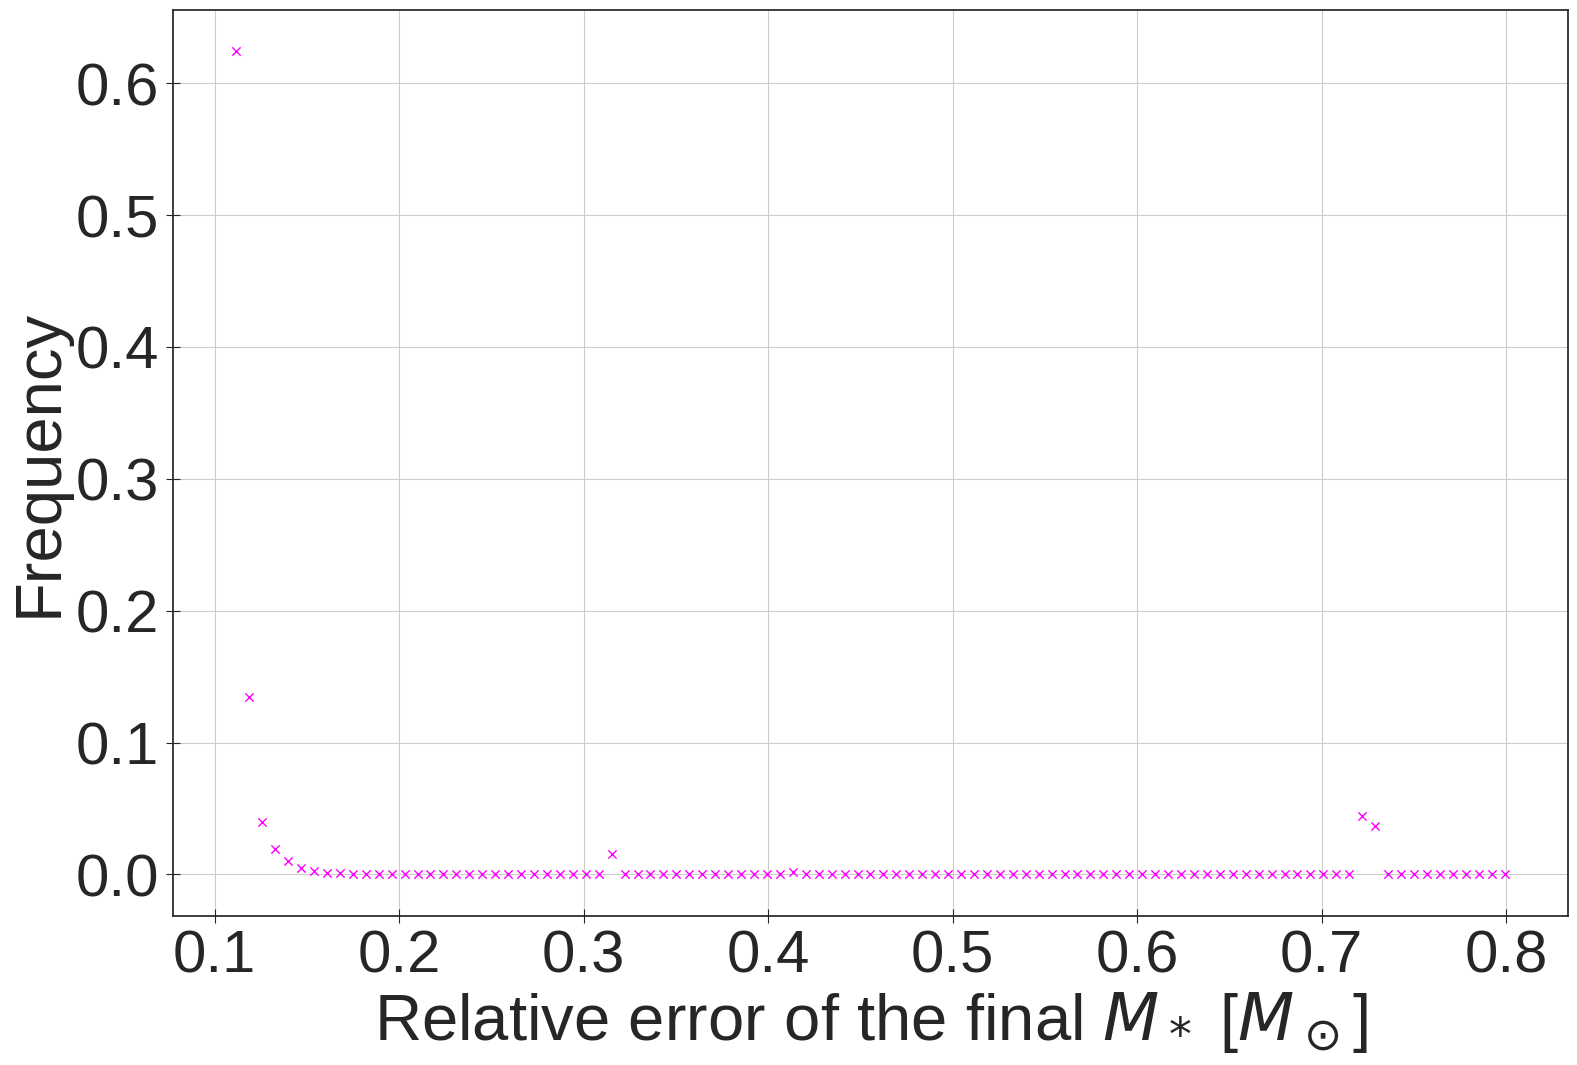

In [29]:
hist_form( 'Relative error of the final $M_*$ [$M_\odot$]', logscale=True )
plt.yscale( 'linear' )
plt.autoscale()

x = data.err_SMass_Kettlety/data.SMass_Kettlety
freq2, bins2 = np.histogram( x, bins = np.linspace( np.min(x), np.max(x), 100 ) )
plt.scatter( bins2[:-1],freq2/len(x),  
            marker = 'x', lw = 1, color = 'magenta', label = 'final' )

plt.grid()
#plt.legend( fontsize = 35 )

### Rounding the stellar masses

First we rounded the errors of stellar masses, then according to this we rounded the values of stellar masses.

In [30]:
data_finalmass = data[~np.isnan(data.SMass_Kettlety)]

In [31]:
def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

# finding the order of the errors:
order_of_err = np.array([ orderOfMagnitude(i) for i in data_finalmass.err_SMass_Kettlety.values ])

# rounding
vals = np.array( [ np.round( data_finalmass.SMass_Kettlety.values[i] / 10**order_of_err[i], 0 ) 
                  for i in range(data_finalmass.shape[0]) ] )
errs = np.array( [ np.round( data_finalmass.err_SMass_Kettlety.values[i] / 10**order_of_err[i], 0 )
                  for i in range(data_finalmass.shape[0]) ] )


# writing the results into the dataframe:
SMass_round = np.zeros( data.shape[0] )
np.add.at( SMass_round, data_finalmass.index, vals*10**order_of_err )

err_SMass_round = np.zeros( data.shape[0] )
np.add.at( err_SMass_round, data_finalmass.index, errs*10**order_of_err )

data['SMass_round'] = SMass_round
data['err_SMass_round'] = err_SMass_round

data.SMass_round.replace(0, np.nan, inplace=True)
data.err_SMass_round.replace(0, np.nan, inplace=True)

In [32]:
data[~np.isnan(data.SMass_Kettlety)]

,GWGC,Hyp,2MASS,wiseX,type,ra,dec,W1,W2,z,...,lumdis_err,w1mCorr,w1mCorrErr,w2mCorr,w2mCorrErr,fromAllSky,SMass_Kettlety,err_SMass_Kettlety,SMass_round,err_SMass_round
1,NGC4548,NGC4548,12352642+1429467,J123526.45+142946.9,G,188.860123,14.496320,9.416,9.306,0.004120,...,3.263033,NaN,NaN,NaN,NaN,NaN,5.481827e+09,2.281279e+09,5.000000e+09,2.000000e+09
3,NGC4442,NGC4442,12280389+0948130,J122803.90+094813.3,G,187.016220,9.803620,8.476,8.504,0.003557,...,2.484465,NaN,NaN,NaN,NaN,NaN,6.801542e+09,2.830483e+09,7.000000e+09,3.000000e+09
4,NGC4469,NGC4469,NaN,J122928.05+084500.8,G,187.367000,8.749890,9.784,9.706,0.004139,...,3.321809,NaN,NaN,NaN,NaN,NaN,3.571210e+09,1.486171e+09,4.000000e+09,1.000000e+09
5,NGC4586,NGC4586,12382843+0419087,J123828.39+041909,G,189.618484,4.319099,10.055,10.041,0.003320,...,1.756102,NaN,NaN,NaN,NaN,NaN,1.386585e+09,5.770319e+08,1.400000e+09,6.000000e+08
6,NGC4440,NGC4440,12275357+1217354,J122753.56+121735.8,G,186.973221,12.293191,9.872,9.947,0.004340,...,3.553836,NaN,NaN,NaN,NaN,NaN,4.641399e+09,1.931533e+09,5.000000e+09,2.000000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22431343,NaN,SDSSJ235402.72+201302.6,NaN,J235402.73+201302.6,G,358.511000,20.217400,14.902,14.744,0.308475,...,NaN,14.902,0.034,14.744,0.062,0.0,1.794782e+11,1.308541e+11,2.000000e+11,1.000000e+11
22431344,NaN,SDSSJ235200.81+201806.7,NaN,J235200.81+201806.7,G,358.003000,20.301880,14.153,13.819,0.200333,...,NaN,14.153,0.029,13.819,0.038,0.0,1.716854e+11,1.251070e+11,2.000000e+11,1.000000e+11
22431345,NaN,SDSSJ235232.35+201806.5,NaN,J235232.36+201806.2,G,358.135000,20.301830,14.678,14.284,0.201158,...,NaN,14.678,0.033,14.284,0.046,0.0,1.066267e+11,7.771431e+10,1.100000e+11,8.000000e+10
22431346,NaN,SDSSJ235039.56+201426.0,NaN,J235039.58+201425.6,G,357.665000,20.240560,14.686,14.440,0.356846,...,NaN,14.686,0.032,14.440,0.051,0.0,2.769915e+11,2.019550e+11,3.000000e+11,2.000000e+11


### The final form of the stellar mass:

The unit of stellar masses will be $10^{10} ~ M_\odot$.

In [33]:
data['SMass_final'] = data.SMass_round/1e10
data['err_SMass_final'] = data.err_SMass_round/1e10

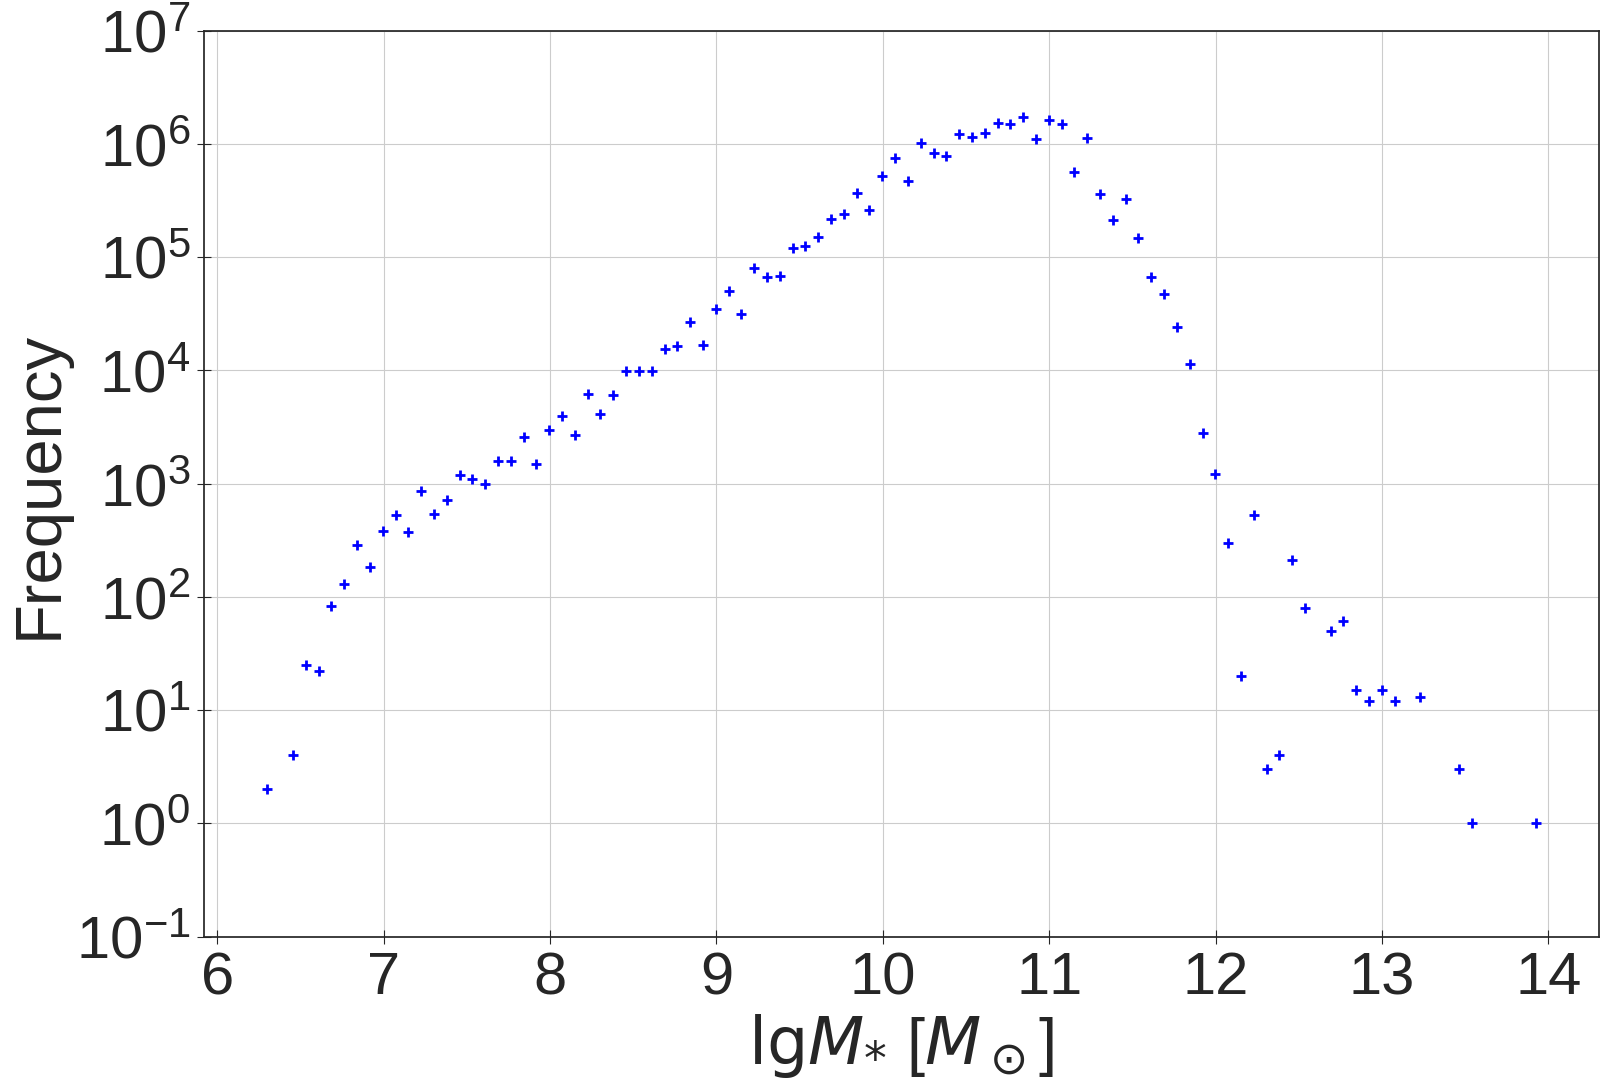

In [34]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(data.SMass_final[~np.isnan(data.SMass_final)]*1e10), bins=100 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 2, s = 50, color = 'blue' ) 
plt.grid()
plt.savefig( 'sm_hist.eps', format = 'eps' ) #save the figure

The effect of the rounding:

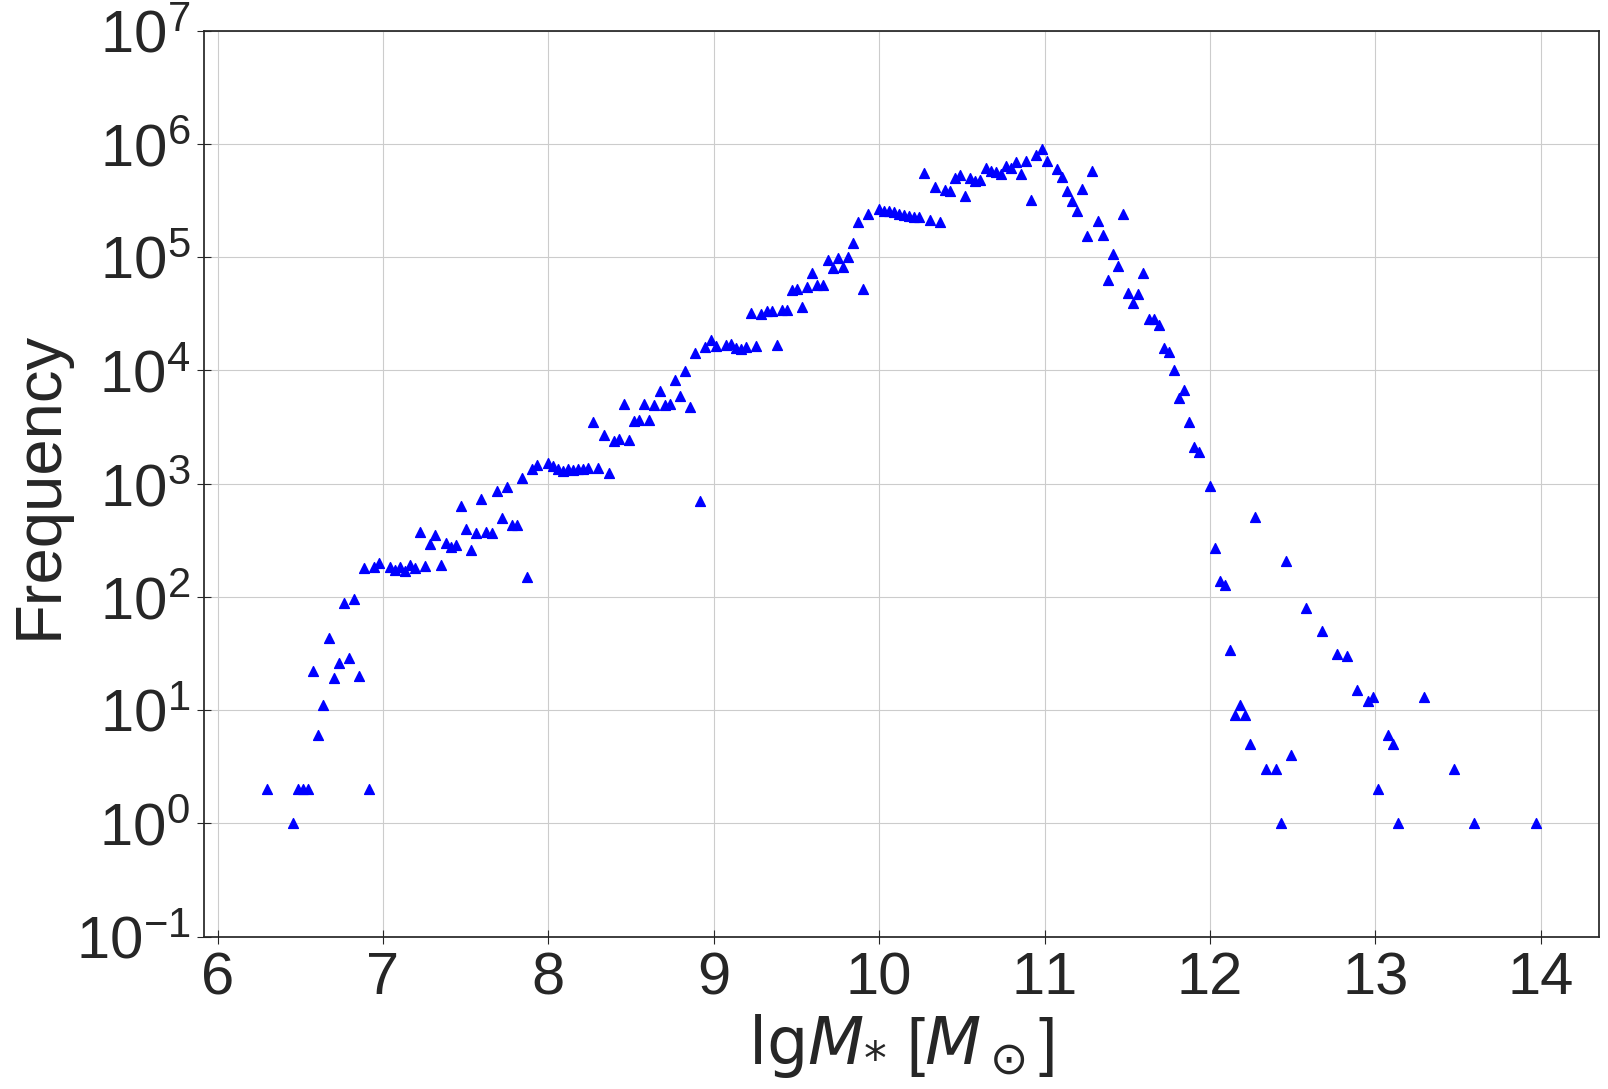

In [35]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(data.SMass_final[~np.isnan(data.SMass_final)]*1e10), bins=250 )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 50, color = 'blue' ) 

plt.grid()

Histogram of the relative error:

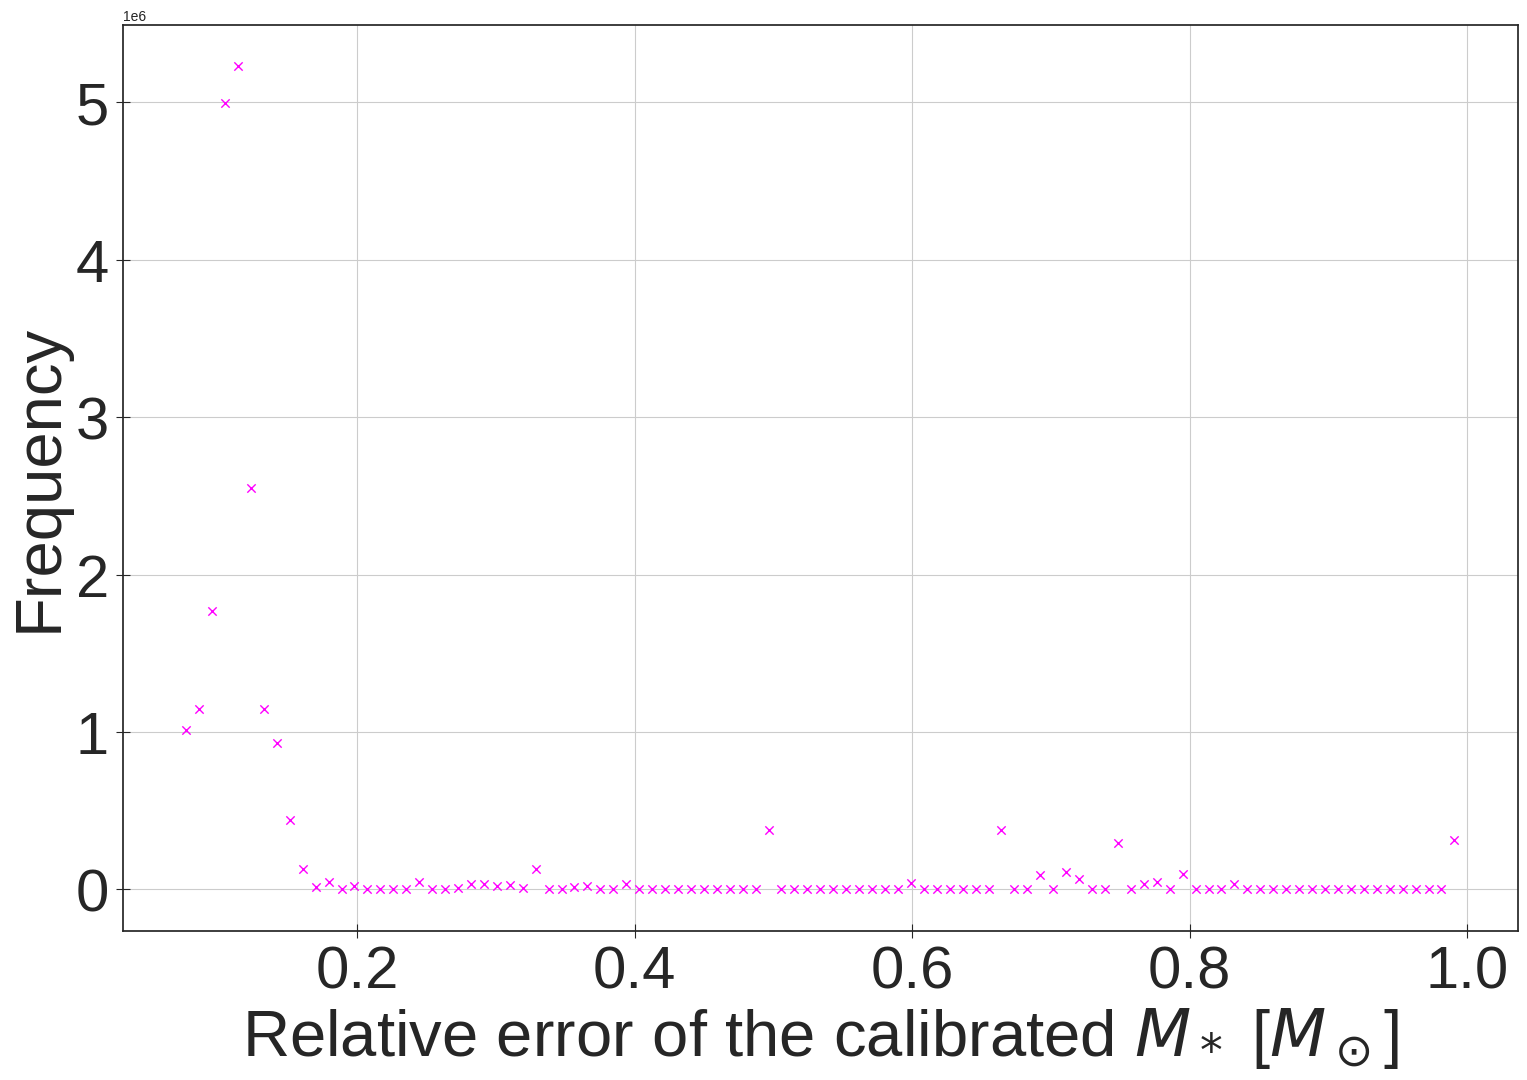

In [36]:
hist_form( 'Relative error of the calibrated $M_*$ [$M_\odot$]', logscale=True )
plt.yscale( 'linear' )
plt.autoscale()

x = data.err_SMass_final/data.SMass_final
freq2, bins2 = np.histogram( x, bins = np.linspace( np.min(x), np.max(x), 100 ) )
plt.scatter( bins2[:-1],freq2, marker = 'x', lw = 1, color = 'magenta' )

plt.grid()

The mean relative error:

In [37]:
np.mean(data.err_SMass_final/data.SMass_final)

0.17239968819854085

## Merger rates:

In the following section I give the merger rates of galaxies in three different scenario: the event of 2 black holes (DBH), two neutron stars (DNS) and a black hole and a neutron star (BHNS).

I use the results of Artale et al. MNRAS 487, 1675–1688 (2019)
 (Host galaxies of merging compact objects: mass, star
formation rate, metallicity and colours):

DNS: $$ \lg(n_{GW}/\text{Gyr}) = ( 1.15 \pm 0.08 ) \lg(M_*[M_{Sun}]) - ( 7.22 \pm 0.22 ), $$

DBH: $$ \lg(n_{GW}/\text{Gyr}) = ( 0.80 \pm 0.07 ) \lg(M_*[M_{Sun}]) - ( 4.14 \pm 0.19 ), $$

BHNS: $$ \lg(n_{GW}/\text{Gyr}) = ( 0.87 \pm 0.08 ) \lg(M_*[M_{Sun}]) - ( 4.99 \pm 0.22 ). $$

They studied the galaxies having stellar mass $M_* > 10^7 ~ M_\odot$ in the local universe $ z \leq 1$.

In [38]:
# find the data whose merger rate can be calculated:
print( 'We need the galaxies which have stellar masses larger than 10^7 and z <= 0.1' )
print('Shape before filtrations:', data.shape)
data_merger =  copy.deepcopy( data[ data.SMass_Kettlety > 10**7 ] )
print( 'Shape with stellar mass > 1e7:', data_merger.shape )
#data_merger =  data_merger[ data_merger.SMass_Kettlety < 10**13 ]  
#print( 'Shape with stellar mass < 1e13:', data_merger.shape )
data_merger = data_merger[ ~np.isnan(data_merger.z) ]  
print('Shape with known redshift:', data_merger.shape)
data_merger = data_merger[ data_merger.z <= 0.1 ]
print('Shape after redshift filtration:', data_merger.shape)
print( 'The shape of dataframe to which we can associate merger rates:' )
print( data_merger.shape )

# merger rate of BNS:
dns = 1.15 * np.log10( data_merger.SMass_Kettlety ) - 7.22
# error of merger rate of BNS:
err_dns = np.sqrt( ( np.log10(data_merger.SMass_Kettlety)*0.08 )**2 + 
                   ( 1.15*data_merger.err_SMass_Kettlety/(data_merger.SMass_Kettlety*np.log(10)) )**2 +
                   0.22**2 )

We need the galaxies which have stellar masses larger than 10^7 and z <= 0.1
Shape before filtrations: (23181758, 23)
Shape with stellar mass > 1e7: (21746339, 23)
Shape with known redshift: (21746339, 23)
Shape after redshift filtration: (3151209, 23)
The shape of dataframe to which we can associate merger rates:
(3151209, 23)


In [39]:
dns[:5], err_dns[:5]

(1    3.979764
 3    4.087498
 4    3.765738
 5    3.293239
 6    3.896646
 Name: SMass_Kettlety, dtype: float64,
 1    0.835833
 3    0.842824
 4    0.821973
 5    0.791505
 6    0.830446
 dtype: float64)

Writing to the dataframe:

In [40]:
data['bns_rate'] = dns
data['err_dns_rate'] = err_dns

### Histograms of the merger rate (and comparision with the stellar mass):

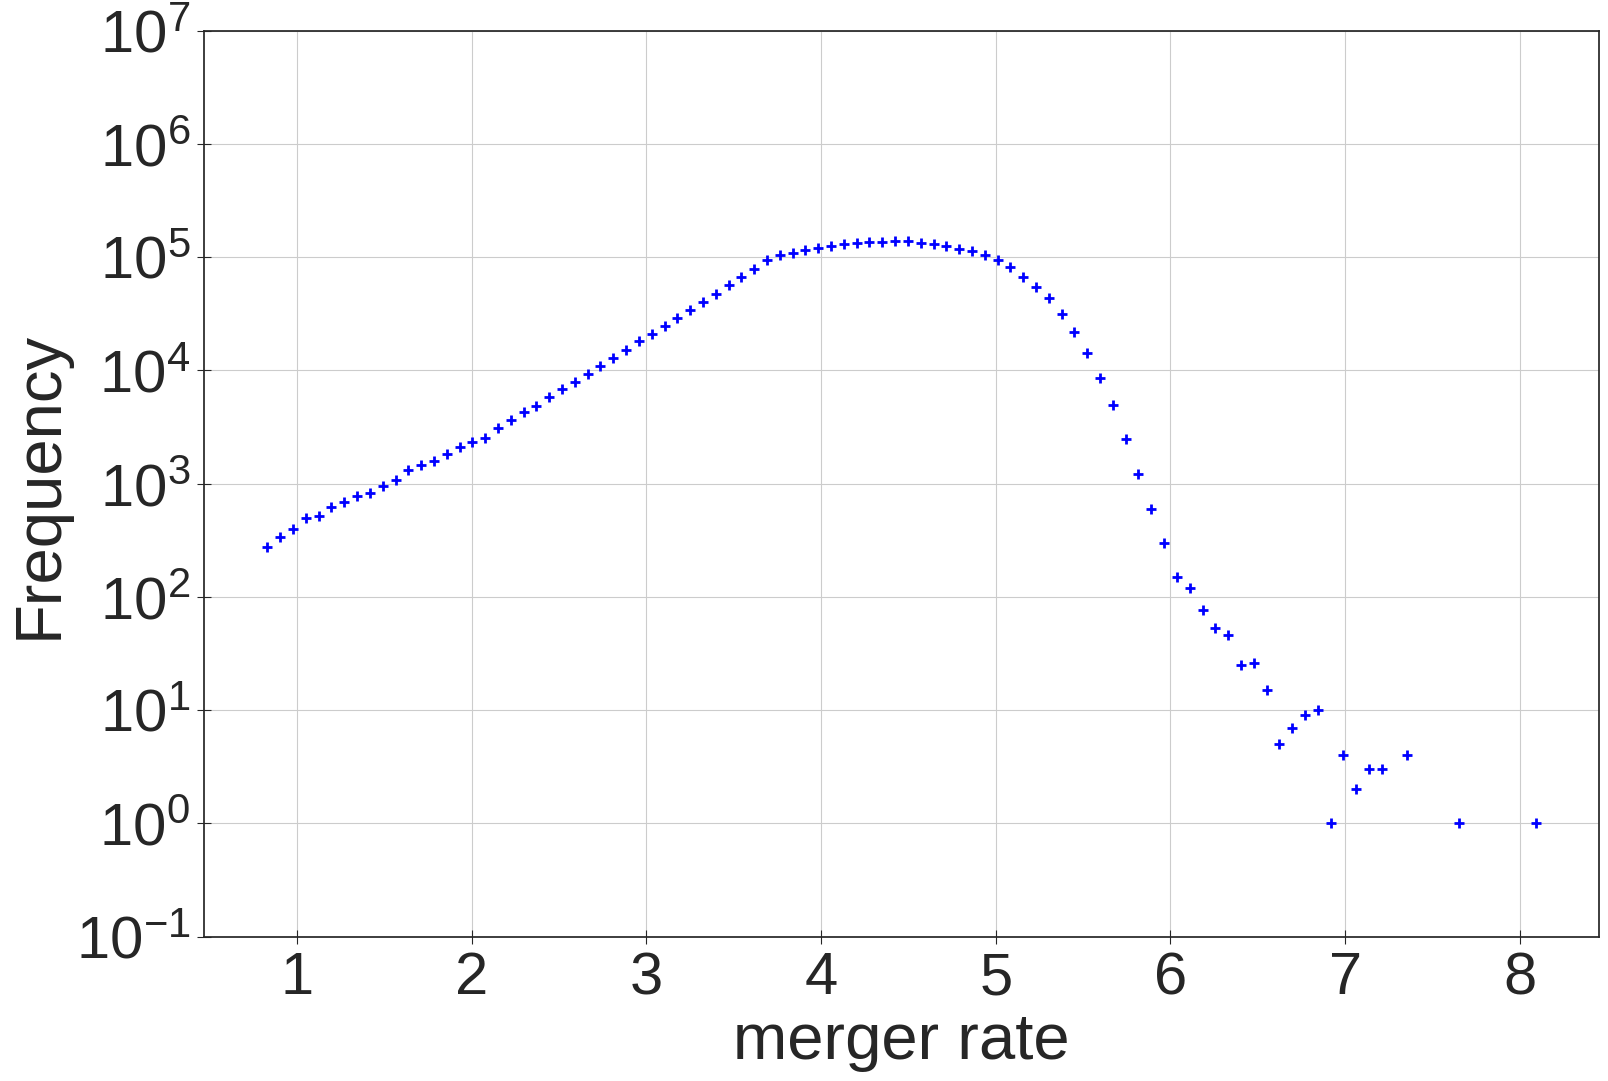

In [41]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)
plt.xlabel('merger rate')

# make and plot histograms:
freq, bins = np.histogram( dns, bins=100 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 2, s = 50, color = 'blue' ) 

plt.grid()

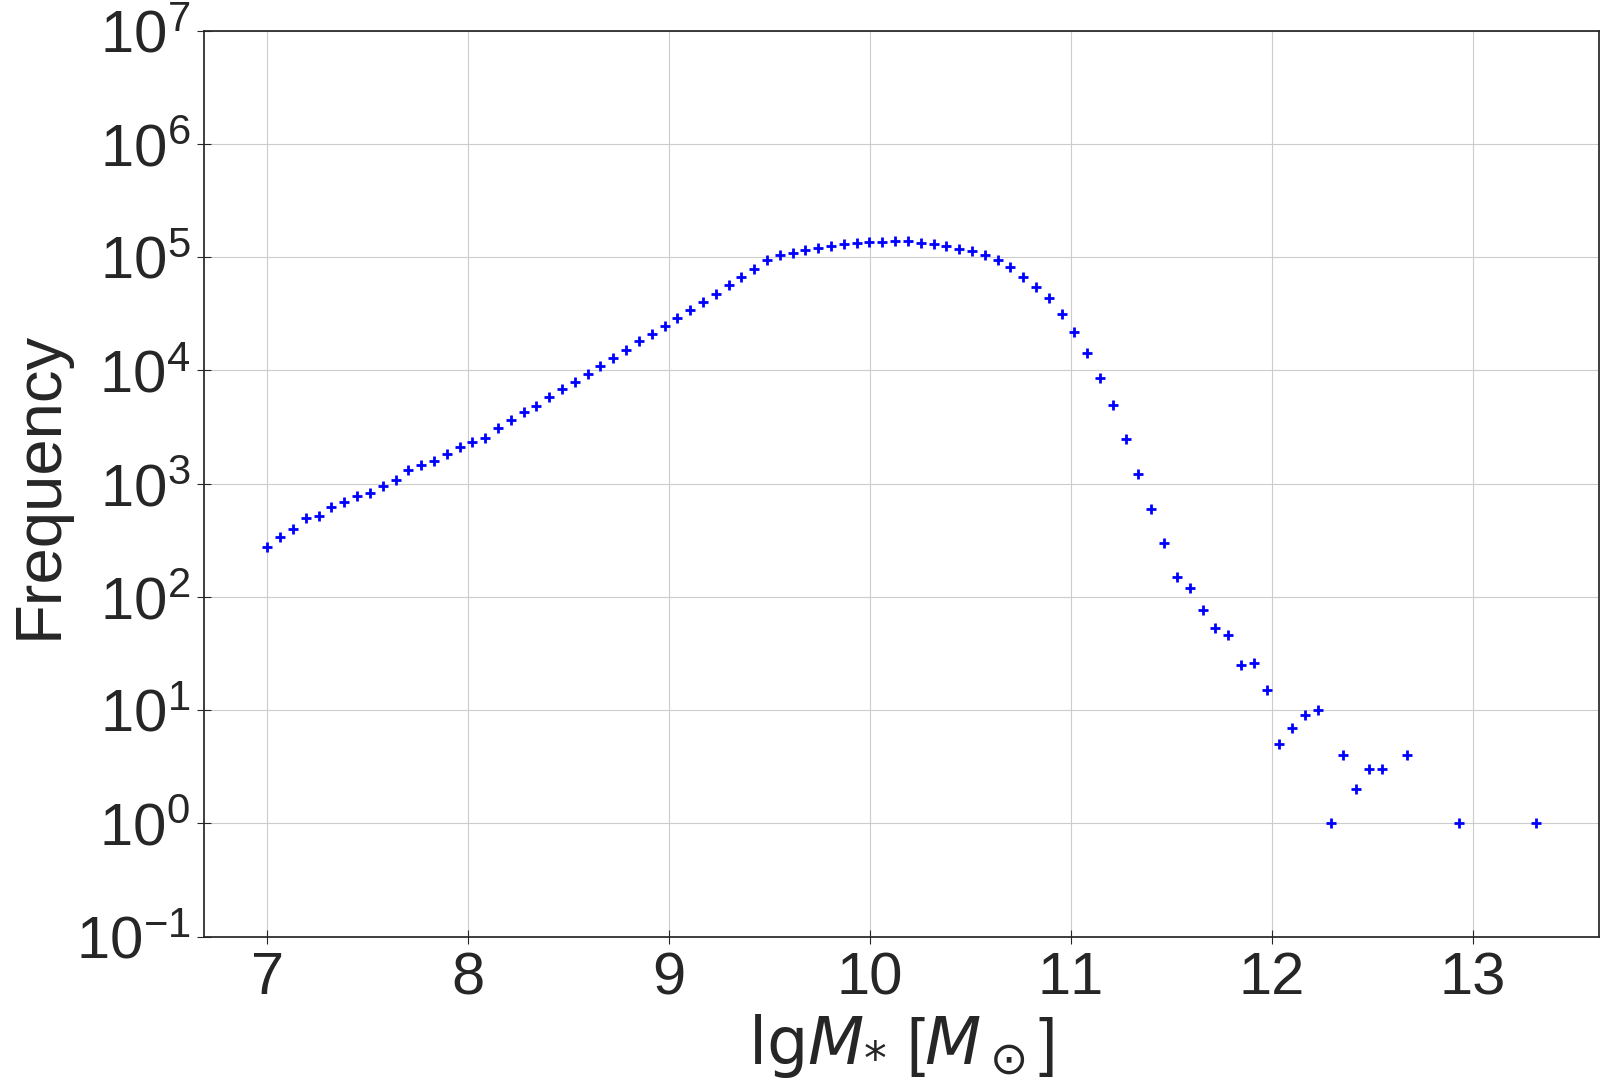

In [42]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)

# make and plot histograms:
freq, bins = np.histogram( np.log10(data_merger.SMass_Kettlety), bins=100 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 2, s = 50, color = 'blue' ) 

plt.grid()

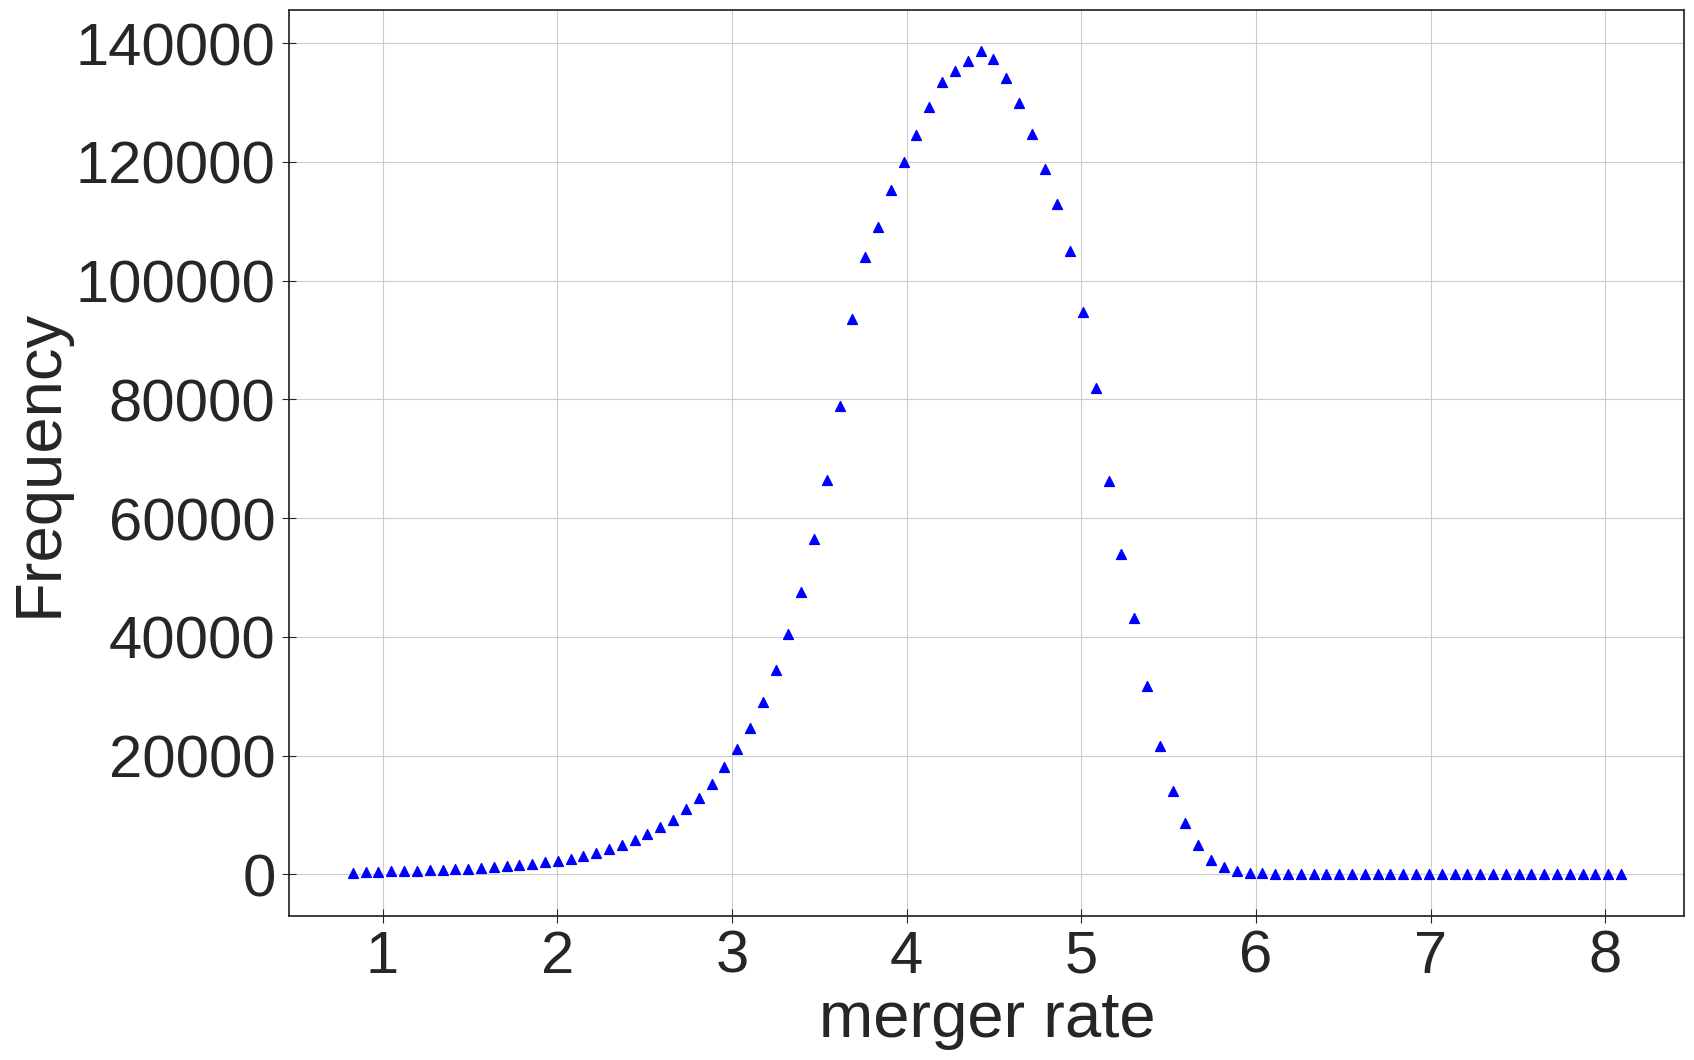

In [43]:
# form the figure:
hist_form()
plt.yscale('linear')
plt.autoscale()
plt.xlabel('merger rate')

# make and plot histograms:
freq, bins = np.histogram( dns, bins=100 )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 50, color = 'blue' ) 

plt.grid()

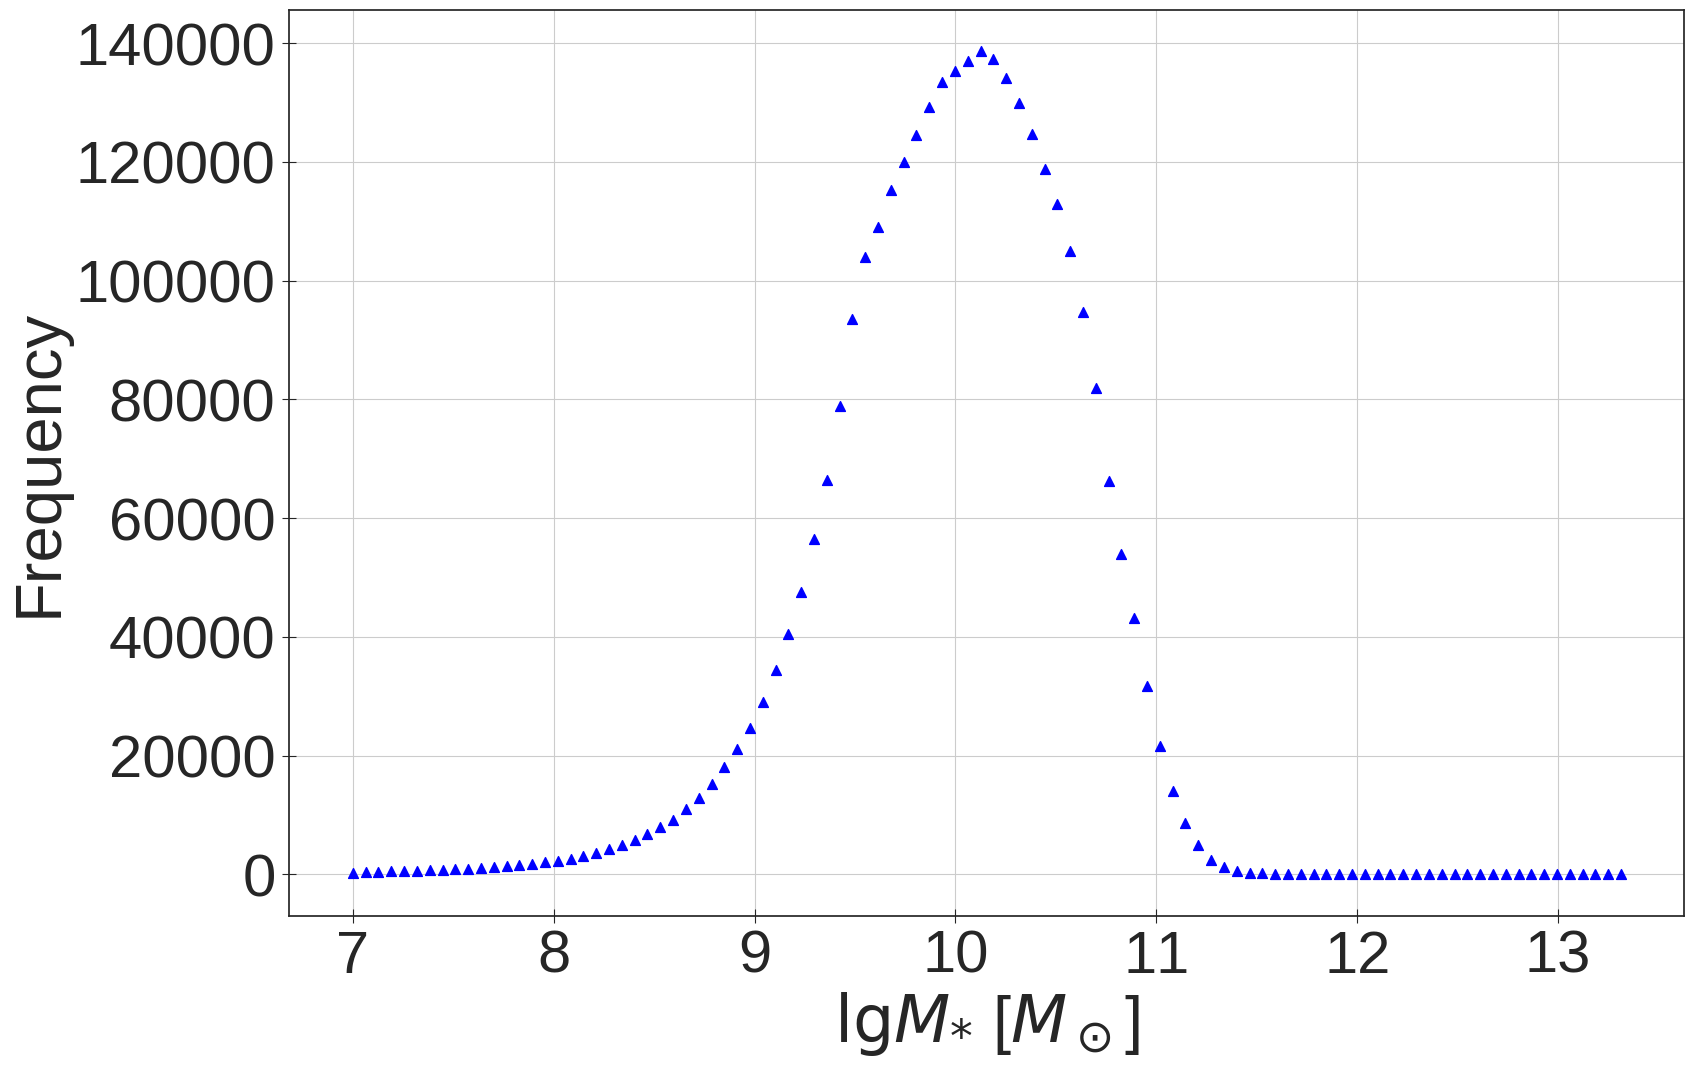

In [44]:
# form the figure:
hist_form()
plt.yscale('linear')
plt.autoscale()

# make and plot histograms:
freq, bins = np.histogram( np.log10(data_merger.SMass_Kettlety), bins=100 )
plt.scatter( bins[:-1], freq,  marker = '^', lw = 1, s = 50, color = 'blue' ) 

plt.grid()

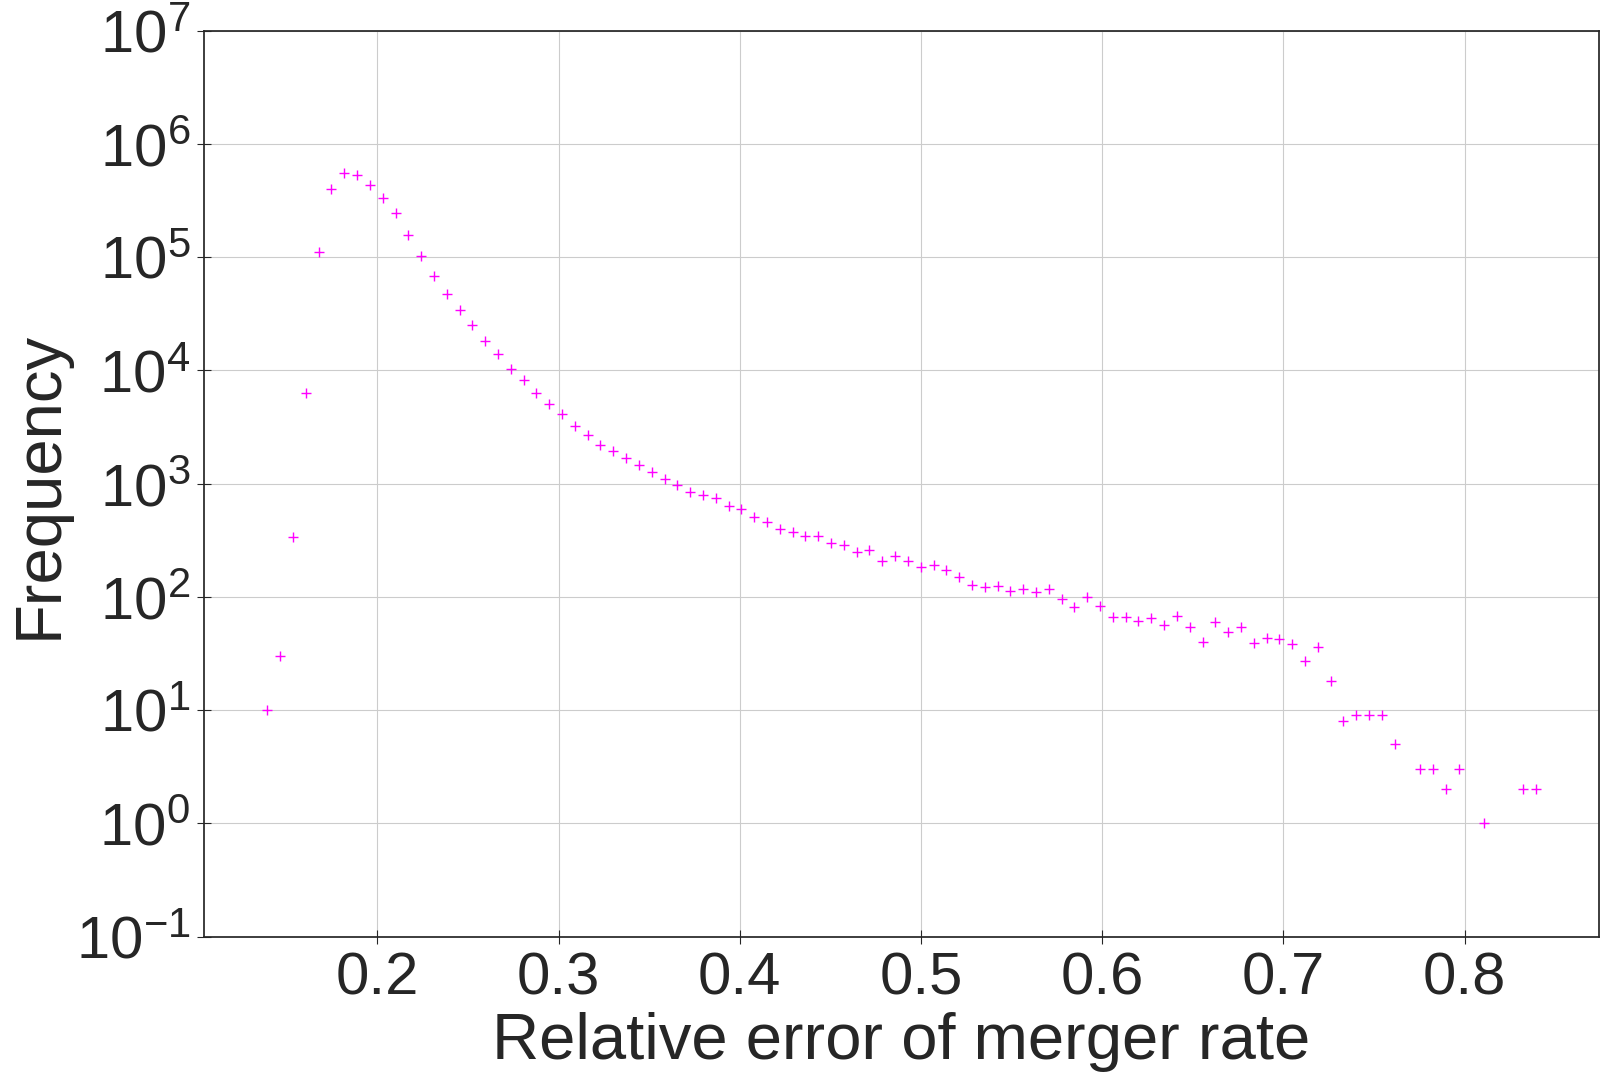

In [45]:
# form the figure:
hist_form()
plt.ylim( 1e-1, 1e7)
plt.xlabel('Relative error of merger rate')

# make and plot histograms:
freq, bins = np.histogram( err_dns/dns, bins=100 )
plt.scatter( bins[:-1], freq,  marker = '+', lw = 1, s = 50, color = 'magenta' ) 

plt.grid()

### Writing data to csv:

In [46]:
data.to_csv( 'original_columns_big.txt',
            columns = [ 'SMass_Kettlety', 'err_SMass_Kettlety', 
                       'bns_rate', 'err_dns_rate' ],
            header=False, index=False )

Rounding the merger rate:

In [47]:
data['bns_rate_rounded'] = np.round(data.bns_rate, 1)
data['err_bns_rate_rounded'] = np.round(data.err_dns_rate, 1)

In [48]:
data[~np.isnan(data.bns_rate)]

,GWGC,Hyp,2MASS,wiseX,type,ra,dec,W1,W2,z,...,SMass_Kettlety,err_SMass_Kettlety,SMass_round,err_SMass_round,SMass_final,err_SMass_final,bns_rate,err_dns_rate,bns_rate_rounded,err_bns_rate_rounded
1,NGC4548,NGC4548,12352642+1429467,J123526.45+142946.9,G,188.860123,14.496320,9.416000,9.306,0.004120,...,5.481827e+09,2.281279e+09,5.000000e+09,2.000000e+09,0.50,0.20,3.979764,0.835833,4.0,0.8
3,NGC4442,NGC4442,12280389+0948130,J122803.90+094813.3,G,187.016220,9.803620,8.476000,8.504,0.003557,...,6.801542e+09,2.830483e+09,7.000000e+09,3.000000e+09,0.70,0.30,4.087498,0.842824,4.1,0.8
4,NGC4469,NGC4469,NaN,J122928.05+084500.8,G,187.367000,8.749890,9.784000,9.706,0.004139,...,3.571210e+09,1.486171e+09,4.000000e+09,1.000000e+09,0.40,0.10,3.765738,0.821973,3.8,0.8
5,NGC4586,NGC4586,12382843+0419087,J123828.39+041909,G,189.618484,4.319099,10.055000,10.041,0.003320,...,1.386585e+09,5.770319e+08,1.400000e+09,6.000000e+08,0.14,0.06,3.293239,0.791505,3.3,0.8
6,NGC4440,NGC4440,12275357+1217354,J122753.56+121735.8,G,186.973221,12.293191,9.872000,9.947,0.004340,...,4.641399e+09,1.931533e+09,5.000000e+09,2.000000e+09,0.50,0.20,3.896646,0.830446,3.9,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22430656,NaN,SDSSJ235636.99+010408.5,NaN,J235636.99+010409.0,G,359.154000,1.069020,15.659000,15.381,0.071254,...,6.368669e+09,4.645920e+09,6.000000e+09,5.000000e+09,0.60,0.50,4.054656,0.892360,4.1,0.9
22430814,ABELL2671:[SBM98]J2354+0522,ABELL2671:[SBM98]J2354+0522,NaN,J235442.78+052254.1,G,358.678000,5.381840,14.040000,13.891,0.010848,...,7.619260e+08,3.162342e+08,8.000000e+08,3.000000e+08,0.08,0.03,2.994200,0.772175,3.0,0.8
22430853,NaN,AGC335023,NaN,J235415.87+063405.6,G,358.566000,6.567780,16.058001,15.908,0.049403,...,2.152334e+09,1.571766e+09,2.000000e+09,2.000000e+09,0.20,0.20,3.512846,0.859582,3.5,0.9
22430891,NaN,AGC335024,NaN,J235507.69+074122.7,G,358.782000,7.689170,15.158000,15.062,0.039533,...,3.475366e+09,2.533057e+09,3.000000e+09,3.000000e+09,0.30,0.30,3.752151,0.873789,3.8,0.9


In [49]:
data.to_csv( 'to_GLADE_columns_big.txt',
            columns = [ 'SMass_final', 'err_SMass_final', 
                       'bns_rate_rounded', 'err_bns_rate_rounded' ],
            header=False, index=False )